*My method of attack on this challenge, is to utilize logistic regression to predict the attribution of relevant variables on the survival of the passsengers.  In order to come up with a list of potential variables that I can regress on, I need to better understand the dataset.*  
In order to better understand the dataset, I'm going to read in the 'traning' set and do some exploratory analysis.  Let's go!  

I will be using Python 2.7, and the pandas, numpy, matplotlib and seaborn libararies to perform my data analysis and prediction.

In [1]:
# Import pandas library for rading in csv and analyzing data frames
# Using 2-character names 'reduces' typing [yeah, I'm lazy! :) ]
import pandas as pd
from pandas import Series, DataFrame

In [2]:
titanic_DF = pd.read_csv("train.csv")

What does the data look like?

In [3]:
titanic_DF.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


Ok, so there are **12 features (columns)**.  Let's see some statistics for this data set.

In [4]:
titanic_DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB


Great!  So, there are **891** entries (rows) and **12** features (columns) per entry.  
I can already see that there are a lot of unknown values (NaN) in the ***Cabin*** column, for example.  

Now, for summary statistics of columns containing non-Null values:

In [5]:
titanic_DF.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PassengerId,891,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


**Observations**:
* 891 passengers in total.
* The survival rate is ~38%.
* A mix of age groups from infants to seniors.
* Hmm, some 'free' fares showing up, and also a very high value of ~512.
* 'Cabin' seems to be missing from the summary, indicating that it it results are thrown away.

Before I start the regression analysis, I need to find  some of the exploratory variables in the data set that could provide a good indication of the survival rates.  

At this point, I'd like to start looking at what the data is telling me.  Questions that pop to my mind are:  
(1) Do passenger Id, tickets, fares and names have anything to do with survival rate?  
(2) Can I ignore cabins, since there are so few "valid" data points related to cabins?  How are cabins and Pclass related to survival rate?  
(3) How does the demography data such as Gender, Family, Socio-Economic-Status (SES), Age relate to survival rate?  
(4) Where did passengers board the Titanic from and does the survival rate depend on the port of embarkment?  

# Question (1) Do tickets, fares and names have anything to do with survival rate?  
***PassengerId***, ***Fare*** and ***Ticket*** (number) can safely be ignored for the analysis, since they don't seem to be providing much value except for book-keeping purposes.  
The same thought process can be applied to remove ***Name*** from the list of usual suspects for the analysis as well.    

# **Question (2) Can I ignore cabins, since there are so few "valid" data related to cabins?  How are Cabin and Pclass (SES), Age related to survival rate**?  
Sub-question: Can I get a distribution of unknowns in the Cabin column?

In [6]:
# Import libraries for data analysis and visualization
import numpy as np
import seaborn as sbn
%matplotlib inline

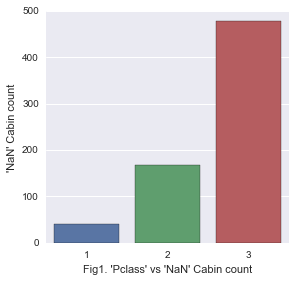

In [7]:
# sbn.factorplot(data=titanic_DF,kind='count',y='Pclass')
cabinNull_DF = DataFrame(titanic_DF[pd.isnull(titanic_DF['Cabin'])])
fig1 = sbn.factorplot(data=cabinNull_DF,kind='count',x='Pclass')
fig1.set_axis_labels("Fig1. 'Pclass' vs 'NaN' Cabin count","'NaN' Cabin count")

So, it is evident from **Fig1.** that most of the unknown cabin information pertains to the 3rd SES (socio-economic status).

The cabin numbers are a combination of an alphabet followed by one or more numbers.  To make it simpler to 'bin' the cabins, I'll retrieve the cabin alphabets for each of the valid cabins in the data set (cabinNotNull_DF).

In [8]:
cabinNotNull_DF = DataFrame(titanic_DF[pd.notnull(titanic_DF['Cabin'])])
cabinTypes = []
for cabin in cabinNotNull_DF['Cabin']:
    cabinTypes.append(cabin[0])
cabinNotNull_DF['CabinType'] = cabinTypes
pd.value_counts(cabinNotNull_DF['CabinType'].values)

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
dtype: int64

**Hmm, there seems to be an odd cabin of type 'T' (perhaps due to a clerical data entry?).  I'll ignore that row for now.**

In [9]:
cabinNotNull_DF = cabinNotNull_DF[cabinNotNull_DF['CabinType'] != 'T']
pd.value_counts(cabinNotNull_DF['CabinType'].values)

C    59
B    47
D    33
E    32
A    15
F    13
G     4
dtype: int64

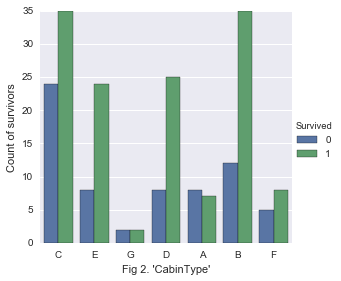

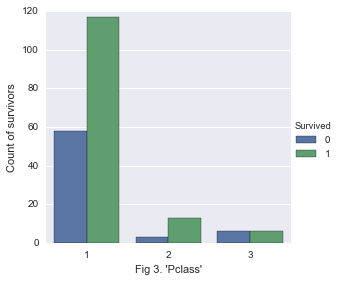

In [10]:
fig2 = sbn.factorplot(data=cabinNotNull_DF,kind='count',hue='Survived',x='CabinType',legend_out=True)
fig2.set_axis_labels("Fig 2. 'CabinType'",'Count of survivors')
fig3 = sbn.factorplot(data=cabinNotNull_DF,kind='count',hue='Survived',x='Pclass',legend_out=True)
fig3.set_axis_labels("Fig 3. 'Pclass'",'Count of survivors')

So, based on **Fig 2.** and **Fig 3.**, we can see that Cabin and SES are certainly good indicators of survivors.  So, I choose to keep **'CabinType'** and **'Pclass'** as potential indicators of survival rate and continue the explorartory analysis.

# **Question (3) How does the demography data (Gender, Family) look?**

Now, I'll look at whether 'Gender' in the cabinNotNull_DF data set is a good indicator of survival and compare that with 'Gender' vs. 'Survived' in the original (titanic_DF) data set.

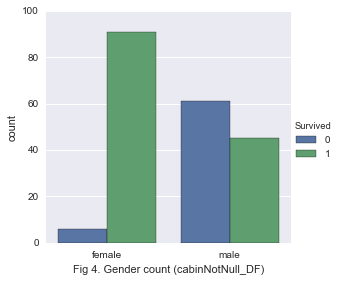

In [11]:
fig4 = sbn.factorplot(data=cabinNotNull_DF,kind='count',x='Sex',hue='Survived')
fig4.set_axis_labels("Fig 4. Gender count (cabinNotNull_DF)")

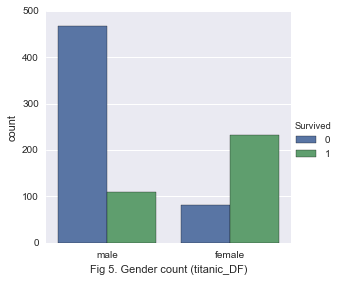

In [12]:
fig5 = sbn.factorplot(data=titanic_DF,kind='count',x='Sex',hue='Survived')
fig5.set_axis_labels("Fig 5. Gender count (titanic_DF)")

**In both cases, gender certainly seems to be a good predictor.  So, I can ignore the rows containing 'Cabin' = NaN, i.e. use cabinNotNull_DF.**  

Next is family data...  

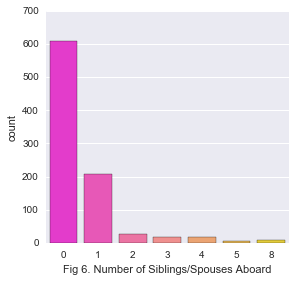

In [13]:
fig6 = sbn.factorplot(data=titanic_DF,kind='count',x='SibSp',palette='spring')
fig6.set_axis_labels("Fig 6. Number of Siblings/Spouses Aboard")

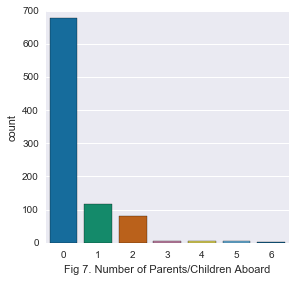

In [14]:
fig7 = sbn.factorplot(data=titanic_DF,kind='count',x='Parch',palette='colorblind')
fig7.set_axis_labels("Fig 7. Number of Parents/Children Aboard")

Ok, so there are more number of people traveling alone, compared to ones that are travelling with family.  For ease of use, I'll bin them into a new column titled **'Alone'**:

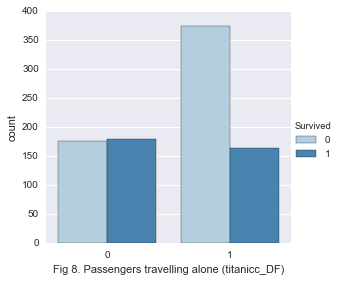

In [15]:
alone = []
for Sib, Fam in zip(titanic_DF['SibSp'], titanic_DF['Parch']):
    if Sib == 0 and Fam ==0 :
        alone.append('1')
    else:
        alone.append('0')
titanic_DF['Alone'] = alone
fig8 = sbn.factorplot(data=titanic_DF,kind='count',x='Alone',hue='Survived',palette='Blues')
fig8.set_axis_labels("Fig 8. Passengers travelling alone (titanicc_DF)")

**That's interesting! Passengers travelling alone seem to have a lower survival rate, compared to ones travelling with family.  So, this seems to be a good exploratory variable for the regression analysis.**  

Now, I'm repeating the above exercise to insert 'Alone' into the cabinNotNull_DF Dataframe.

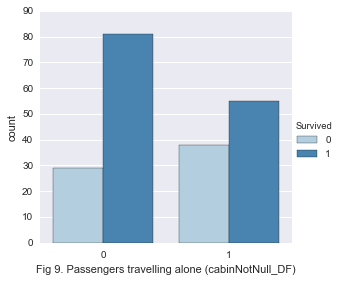

In [16]:
alone = []
for Sib, Fam in zip(cabinNotNull_DF['SibSp'], cabinNotNull_DF['Parch']):
    if Sib == 0 and Fam ==0 :
        alone.append('1')
    else:
        alone.append('0')
cabinNotNull_DF['Alone'] = alone
fig9 = sbn.factorplot(data=cabinNotNull_DF,kind='count',x='Alone',hue='Survived',palette='Blues')
fig9.set_axis_labels("Fig 9. Passengers travelling alone (cabinNotNull_DF)")

This re-inforces the earlier statement.

And finally, the Age factor:

In [17]:
cabinNotNull_DF = cabinNotNull_DF[pd.notnull(cabinNotNull_DF['Age'])]
cabinNotNull_DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184 entries, 1 to 889
Data columns (total 14 columns):
PassengerId    184 non-null int64
Survived       184 non-null int64
Pclass         184 non-null int64
Name           184 non-null object
Sex            184 non-null object
Age            184 non-null float64
SibSp          184 non-null int64
Parch          184 non-null int64
Ticket         184 non-null object
Fare           184 non-null float64
Cabin          184 non-null object
Embarked       182 non-null object
CabinType      184 non-null object
Alone          184 non-null object
dtypes: float64(2), int64(5), object(7)
memory usage: 21.6+ KB


Here's what the distribution looks like in the cabinNotNull_DF DataFrame:

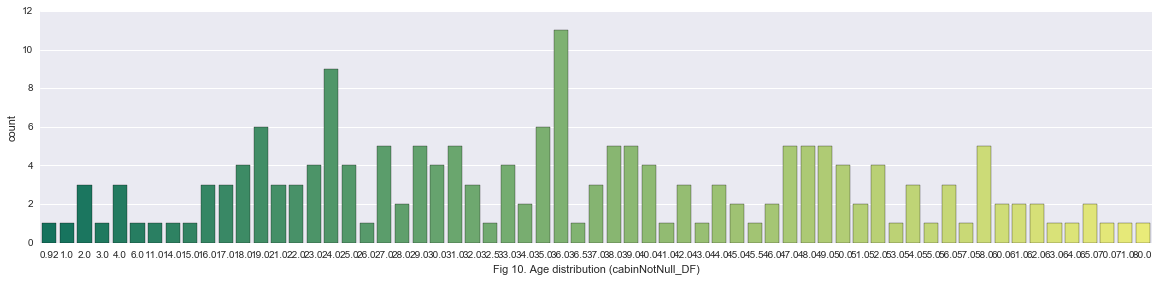

In [18]:
import matplotlib.pyplot as mp
from scipy import stats
import math
fig10 = sbn.factorplot(data=cabinNotNull_DF,kind='count',x='Age',palette='summer',aspect=4)
fig10.set_axis_labels("Fig 10. Age distribution (cabinNotNull_DF)")

Let's see if binning ages helps refine the picture.  Just like the process for 'Cabin', I am going to bin 'Age', and compare the survival rate for those silos.  The binning ranges are evident from the Python code.

In [19]:
def age_to_silos(ageVal):
    if ageVal  < 20 :
        return "Child"
    elif ageVal < 30 :
        return "Twenties"
    elif ageVal < 40 :
        return "Thirties"
    elif ageVal < 50 :
        return "Forties"
    elif ageVal < 65 :
        return "Fifties"
    else:
        return "Seniors"
AgeSilos = []
for silos in cabinNotNull_DF['Age']:
    AgeSilos.append(age_to_silos(silos))
cabinNotNull_DF['AgeSilos'] = AgeSilos
pd.value_counts(cabinNotNull_DF['AgeSilos'].values)

/Users/rajeshgopalan/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Thirties    50
Twenties    36
Fifties     32
Forties     32
Child       29
Seniors      5
dtype: int64

Now to visualize the Age silos against the survivors.

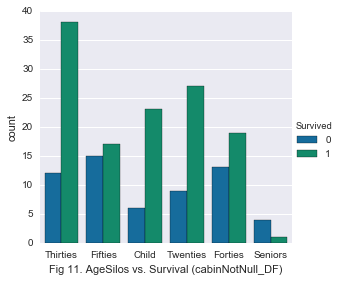

In [20]:
fig11 = sbn.factorplot(data=cabinNotNull_DF,kind='count',x='AgeSilos',palette='colorblind',hue='Survived')
fig11.set_axis_labels("Fig 11. AgeSilos vs. Survival (cabinNotNull_DF)")

Ok, 'Age' seems to be a good predictor of survival rate.

# Question (4) Where did passengers board the Titanic from and does the survival rate depend on the port of embarkment?

In [21]:
pd.value_counts(titanic_DF['Embarked'].values)

S    644
C    168
Q     77
dtype: int64

There are three ports from which passegners boarded the ship.  Let's get a histogram of the survival rate of passengers from each of these ports.

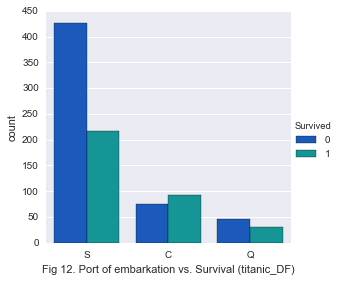

In [22]:
fig12 = sbn.factorplot(data=titanic_DF,kind='count',x='Embarked',palette='winter', hue ='Survived')
fig12.set_axis_labels("Fig 12. Port of embarkation vs. Survival (titanic_DF)")

Now, I'm repeating the above exercise to for the cabinNotNull_DF Dataframe.

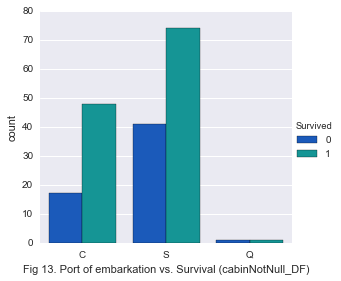

In [23]:
fig13 = sbn.factorplot(data=cabinNotNull_DF,kind='count',x='Embarked',palette='winter', hue ='Survived')
fig13.set_axis_labels("Fig 13. Port of embarkation vs. Survival (cabinNotNull_DF)")

**Ok, this indicates that port of embarkation should be a good predictor of survival rate.**  

I have my four questions answered now.  Time to run a logistic regression on the following explorarory variables:  
Age  
Pclass  
Alone  
Sex  
CabinType  
Embarked  

The target variable is 'Survived'.  

Now, I will create 'Categorical' variables (dummies) for the explanatory variables that are non-numeric, giving them appropriate names so that I can run the regression and interpret the coefficients.  When creating dummies, I need to ensure that I remove one of the dummies from the list, so that I avoid multi-collinearity. 

In [24]:
SexDummies = pd.get_dummies(cabinNotNull_DF['Sex'])
CabinTypeDummies = pd.get_dummies(cabinNotNull_DF['CabinType'])
EmbarkedDummies = pd.get_dummies(cabinNotNull_DF['Embarked'])
CabinTypeDummies.columns = ['CabinA','CabinB','CabinC','CabinD','CabinE','CabinF','CabinG']
CabinTypeDummies = CabinTypeDummies.drop('CabinA',axis=1)
EmbarkedDummies.columns = ['EmbarkedC','EmbarkedQ','EmbarkedS']
EmbarkedDummies = EmbarkedDummies.drop('EmbarkedS',axis=1)

In [25]:
Training_DF = cabinNotNull_DF.drop(['SibSp','PassengerId','Parch','Name','Ticket','Fare','CabinType','Sex','Embarked','Cabin','AgeSilos'],axis=1)
Training_DF = pd.concat([Training_DF,SexDummies,CabinTypeDummies,EmbarkedDummies],axis=1)
Training_DF.head()

,Survived,Pclass,Age,Alone,female,male,CabinB,CabinC,CabinD,CabinE,CabinF,CabinG,EmbarkedC,EmbarkedQ
1,1,1,38,0,1,0,0,1,0,0,0,0,1,0
3,1,1,35,0,1,0,0,1,0,0,0,0,0,0
6,0,1,54,1,0,1,0,0,0,1,0,0,0,0
10,1,3,4,0,1,0,0,0,0,0,0,1,0,0
11,1,1,58,1,1,0,0,1,0,0,0,0,0,0


Ok, now the data frame is in a format that I can run logistic regression on!

Lets separate the target variable from the predictor variables and put the target variable in an 'array' format as required by scikit.

In [248]:
Y = np.ravel(Training_DF['Survived'])
X = Training_DF.drop('Survived',axis=1)
X['Age'] = X.Age.astype(int)

In [249]:
# Machine Learning Imports
from sklearn.linear_model import LogisticRegression
# For evaluating our ML results
from sklearn import metrics

glm_Training = LogisticRegression()
glm_Training.fit(X,Y)
glm_Training.score(X,Y)

0.80434782608695654

So, that's an 80% accuracy rating for the Logitic Regression model.
How does this compare to a simple 'guess' of Survived = 0 for every passenger?
I can get this by comparing the percentage of survivors in the training set, i.e. the mean of the survivors.  Technically, I'm check the "null error rate".  

Now let's use statsmodels and rerun the logistic regression and get a summary of the result:

In [250]:
Y.mean()

0.67934782608695654

This means, if I had simply guessed "Survived = 0" for every pasenger, I would have had 1 - 0.68 = .32 or 32% accuracy.  So, the logistic model is already doing a much better job than my simplistic 'guess' model.  
I'll now check the coefficients of my logistic model, to see the prediction strengths of the explanatory variables.

In [255]:
glmCoeff_DF = DataFrame([['Intercept',glm_Training.intercept_]])
glmCoeff_DF = glmCoeff_DF.append(DataFrame(zip(X.columns,np.transpose(glm_Training.coef_))),ignore_index=True)
np.float64(glm_Training.intercept_)
glmCoeff_DF

,0,1
0,Intercept,[1.44421966441]
1,Pclass,[-0.257145450058]
2,Age,[-0.0270082412089]
3,Alone,[-0.106201165284]
4,female,[2.03202098493]
5,male,[-0.587801320527]
6,CabinB,[0.235992830441]
7,CabinC,[-0.464262181352]
8,CabinD,[0.307634704877]
9,CabinE,[0.717813494371]


Since this doesn't provide details of satistical significance of the coefficient, I am going to use statsmodels, rerun the logistic regression and get a summary of the result:

In [256]:
import statsmodels.api as sma

Survived = np.int16(Training_DF['Survived'])
X_array = np.int16(X)
yName = 'Survived'
xName = map(lambda X_columnNames: X_columnNames, X.columns)
logit = sma.Logit(Survived,X_array)
result = logit.fit()
result.summary(yname=yName,xname=xName)

Optimization terminated successfully.
         Current function value: 0.402269
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  184
Model:                          Logit   Df Residuals:                      171
Method:                           MLE   Df Model:                           12
Date:                Sun, 14 Feb 2016   Pseudo R-squ.:                  0.3588
Time:                        11:42:25   Log-Likelihood:                -74.018
converged:                       True   LL-Null:                       -115.43
                                        LLR p-value:                 1.186e-12
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Pclass        -0.2732      0.665     -0.411      0.681        -1.576     1.029
Age           -0.0432      0.015     -2.893      0.004        -0.072    -0.014
Alone         -0.4212      0.461     -0.913      0.361        -1.325     0.483
female         5.9958      1.395      4.300      0.000         3.263     8.729
male           2.4908      1.220      2.041      0.041         0.099     4.882
CabinB        -0.7032      0.818     -0.860      0.390        -2.306     0.899
CabinC        -1.7025      0.837     -2.033      0.042        -3.344    -0.061
CabinD        -0.6279      0.877     -0.716      0.474        -2.348     1.092
CabinE         0.0743      0.879      0.084      0.933        -1.649     1.798
CabinF        -1.0638      1.432     -0.743      0.458        -3.871     1.744
CabinG        -4.5393      2.019     -2.248      0.025        -8.496    -0.582
EmbarkedC      0.4804      0.481      0.998      0.318        -0.463     1.424
EmbarkedQ     -0.6039      2.229     -0.271      0.786        -4.972     3.764
==============================================================================
"""

Ok, now I'm going to run this model on the test data set that has been provided.  But, I will need to "clean up" the **test data set** and put it in a format similar to the **training data set**, for my model to work properly.  These steps are a repeat of what was done on the training data set:

In [257]:
titanic_test_DF = pd.read_csv("test.csv")
titanic_test_DF = DataFrame(titanic_test_DF[pd.notnull(titanic_test_DF['Cabin'])])
cabinTypes = []
for cabin in titanic_test_DF['Cabin']:
    cabinTypes.append(cabin[0])
titanic_test_DF['CabinType'] = cabinTypes
alone = []
for Sib, Fam in zip(titanic_test_DF['SibSp'], titanic_test_DF['Parch']):
    if Sib == 0 and Fam ==0 :
        alone.append('1')
    else:
        alone.append('0')
titanic_test_DF['Alone'] = alone
titanic_test_DF = titanic_test_DF[pd.notnull(titanic_test_DF['Age'])]
SexDummies = pd.get_dummies(titanic_test_DF['Sex'])
CabinTypeDummies = pd.get_dummies(titanic_test_DF['CabinType'])
EmbarkedDummies = pd.get_dummies(titanic_test_DF['Embarked'])
CabinTypeDummies.columns = ['CabinA','CabinB','CabinC','CabinD','CabinE','CabinF','CabinG']
CabinTypeDummies = CabinTypeDummies.drop('CabinA',axis=1)
EmbarkedDummies.columns = ['EmbarkedC','EmbarkedQ','EmbarkedS']
EmbarkedDummies = EmbarkedDummies.drop('EmbarkedS',axis=1)
Test_DF = titanic_test_DF.drop(['SibSp','PassengerId','Parch','Name','Ticket','Fare','CabinType','Sex','Embarked','Cabin'],axis=1)
Test_DF = pd.concat([Test_DF,SexDummies,CabinTypeDummies,EmbarkedDummies],axis=1)
X['Age'] = X.Age.astype(int)

In [258]:
Test_predict = glm_Training.predict(Test_DF)